# Deep Q-Learning and Variants in Gym's Acrobot
In this notebook, we will explore the implementation of a Deep Q-Learning (DQN) agent to navigate Gym's Acrobot environment.

We will use apply two variants of the DQN algorithm:

- The Classic DQN (Mihn et al 2013)
- N-Step DQN (2, 3 and 4 steps)
- More to be added in future

The Acrobot environment tasks an agent with controlling a two-link robot to reach a specific height starting from a hanging position. The agent can apply torque to the joint between the two links, aiming to swing the acrobot, build momentum, and achieve the target height in as few steps as possible. The challenge is managing the system's physics, where limited direct control requires the agent to strategically apply torque at the right times to reach the goal.

All reinforcement learning (RL) methods will be built from scratch, providing a comprehensive understanding of their workings and we will use PyTorch to build our neural network model.

Let's initialize an Acrobot-v1 environmnet, make random actions in the environment, then view a recording of it.

In [2]:
!pip install swig 
!pip install gym[box2d]

  Obtaining dependency information for swig from https://files.pythonhosted.org/packages/32/5a/fd3de7fa6ef45b8bb39723de65aeedbe7b213ee397d2e9fa9fefe0507636/swig-4.3.0-py2.py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB 682.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.6 MB 1.1 MB/s eta 0:00:03
   ---- ----------------------------------- 0.3/2.6 MB 2.2 MB/s eta 0:00:02
   ----------- ---------------------------- 0.7/2.6 MB 4.2 MB/s eta 0:00:01
   -------------------- ------------------- 1.3/2.6 MB 5.9 MB/s eta 0:00:01
   ----------------------------- ---------- 1.9/2.6 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------  2.5/2.6 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 7.8 MB/s eta 0:00:00


  Using cached gym-0.26.2-py3-none-any.whl
  Obtaining dependency information for gym_notices>=0.0.4 from https://files.pythonhosted.org/packages/25/26/d786c6bec30fe6110fd3d22c9a273a2a0e56c0b73b93e25ea1af5a53243b/gym_notices-0.0.8-py3-none-any.whl.metadata
  Using cached box2d_py-2.3.5-cp310-cp310-win_amd64.whl
  Obtaining dependency information for pygame==2.1.0 from https://files.pythonhosted.org/packages/e0/ce/1215d864989d25cb7b234759ce6a760813dffe2e707df7f8e3e748538ba0/pygame-2.1.0-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/4.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.8 MB 640.0 kB/s eta 0:00:08
    --------------------------------------- 0.1/4.8 MB 1.1 MB/s eta 0:00:05
   -- ------------------------------------- 0.3/4.8 MB 2.5 MB/s eta 0:00:02
   ------ --------------------------------- 0.8/4.8 MB 4.8 MB/s eta 0:00:01
   ----------------- ---------------------- 2.1/4.8 MB 9.4 MB/s eta 0:00:01
   --------------------

In [17]:
import gym
import torch
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [5]:

env = gym.make('Acrobot-v1')
env.reset(seed=42)

# Play one complete episode with random actions
while True:
    action = env.action_space.sample() 
    _, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    
env.close()

c:\Users\crist\.conda\envs\deep-learning\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


![](https://i.imgur.com/0bdwRIt.gif)

## Acrobot General Information
This information is from the official Gym documentation.

https://www.gymlibrary.dev/environments/classic/acrobot/

| Feature Category  | Details                                |
|-------------------|----------------------------------------|
| Action Space      | Discrete(3)                            |
| Observation Shape | (6,)                                   |
| Observation High  | [1 1 1 1 12.566371 28.274334]          |
| Observation Low   | [-1 -1 -1 -1 -12.566371 -28.274334]    |
| Import            | `gym.make("Acrobot-v1")`               |

## Description of Environment

The Acrobot environment consists of a two-link structure, with the joint between the two links actuated. Initially, both links hang downwards. The goal is to apply torques on the actuated joint to swing the free end of the outer-link above a line that is a certain height above the base.

## Action Space
The action is the torque applied to the joint connecting the two links.

| Action  | Result                | Unit        |
|---------|-----------------------|-------------|
| 0       | Apply -1 torque       | Torque (N m)|
| 1       | Apply 0 torque        | Torque (N m)|
| 2       | Apply 1 torque        | Torque (N m)|

## Observation Space
The observation provides information about the two joint angles and their angular velocities.

| Observation                | Min                 | Max              |
|----------------------------|---------------------|------------------|
| Cosine of theta1           | -1                  | 1                |
| Sine of theta1             | -1                  | 1                |
| Cosine of theta2           | -1                  | 1                |
| Sine of theta2             | -1                  | 1                |
| Angular velocity of theta1 | ~ -12.567 (-4 * pi) | ~ 12.567 (4 * pi)|
| Angular velocity of theta2 | ~ -28.274 (-9 * pi) | ~ 28.274 (9 * pi)|

Where:

- theta1 is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly downwards.
- theta2 is relative to the angle of the first link. An angle of 0 corresponds to having the same angle between the two links.

## Rewards
All steps that do not reach the goal incur a reward of -1. Reaching the goal results in termination with a reward of 0. The reward threshold is -100.

## Starting State
Each parameter in the state (theta1, theta2, and the two angular velocities) is initialized uniformly between -0.1 and 0.1. This implies that both links are pointing downwards with some initial stochasticity.

## Episode Termination
The episode ends if:

1. The free end reaches the target height, which is defined by: -cos(theta1) - cos(theta2 + theta1) > 1.0.
2. The episode length is greater than 500 steps.

---

## Applying Normal DQN
First we're going to train an agent implementing the basic DQN algorithm described by Mihn et al at DeepMind in 2013. This algorithm is explained in detail in my Lunar Lander notebook.

In [29]:

class DQN(torch.nn.Module):
    '''
    This class defines a deep Q-network (DQN), a type of artificial neural network used in reinforcement learning.
    The DQN is used to estimate the Q-values, which represent the expected return for each action in each state.
    
    Parameters
    ----------
    state_size: int, default=6
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    '''
    def __init__(self, state_size=6, action_size=3, hidden_size=64):
        '''
        Initialize a network with the following architecture:
            Input layer (state_size, hidden_size)
            Hidden layer 1 (hidden_size, hidden_size)
            Output layer (hidden_size, action_size)
        '''
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, 128)
        self.layer3 = torch.nn.Linear(128, hidden_size)
        self.layer4 = torch.nn.Linear(hidden_size, 24)
        self.layer5 = torch.nn.Linear(24, action_size)

    def forward(self, state):
        '''
        Define the forward pass of the DQN. This function is called when the network is called to estimate Q-values.
        
        Parameters
        ----------
        state: torch.Tensor
            The state for which to estimate the Q-values.

        Returns
        -------
        torch.Tensor
            The estimated Q-values for each action in the input state.
        '''
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        return self.layer5(x)
    


class ReplayBuffer:
    '''
    This class represents a replay buffer, a type of data structure commonly used in reinforcement learning algorithms.
    The buffer stores past experiences in the environment, allowing the agent to sample and learn from them at later times.
    This helps to break the correlation of sequential observations and stabilize the learning process.
    
    Parameters
    ----------
    buffer_size: int, default=10000
        The maximum number of experiences that can be stored in the buffer.
    '''
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        '''
        Add a new experience to the buffer. Each experience is a tuple containing a state, action, reward,
        the resulting next state, and a done flag indicating whether the episode has ended.

        Parameters
        ----------
        state: array-like
            The state of the environment before taking the action.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        '''
        Randomly sample a batch of experiences from the buffer. The batch size must be smaller or equal to the current number of experiences in the buffer.

        Parameters
        ----------
        batch_size: int
            The number of experiences to sample from the buffer.

        Returns
        -------
        tuple of numpy.ndarray
            A tuple containing arrays of states, actions, rewards, next states, and done flags.
        '''
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        '''
        Get the current number of experiences in the buffer.

        Returns
        -------
        int
            The number of experiences in the buffer.
        '''
        return len(self.buffer)
    
class DQNAgent:
    '''
    This class represents a Deep Q-Learning agent that uses a Deep Q-Network (DQN) and a replay memory to interact 
    with its environment.

    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    learning_rate: float, default=1e-3
        The learning rate for the optimizer.
    gamma: float, default=0.99
        The discount factor for future rewards.
    buffer_size: int, default=10000
        The maximum size of the replay memory.
    batch_size: int, default=64
        The batch size for learning from the replay memory.
    '''
    def __init__(self, state_size=6, action_size=3, hidden_size=128, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        
        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Set target network to evaluation mode
        self.target_network.eval()

        # Initialize the optimizer for updating the Q-Network's parameters
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        '''
        Perform a step in the environment, store the experience in the replay memory and potentially update the Q-network.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)
        
        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        '''
        Choose an action based on the current state and the epsilon-greedy policy.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        eps: float, default=0.
            The epsilon for the epsilon-greedy policy. With probability eps, a random action is chosen.

        Returns
        -------
        int
            The chosen action.
        '''
        # If a randomly chosen value is greater than eps
        if random.random() > eps:  
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        '''
        Update the weights of the target network to match those of the Q-network.
        '''
        self.target_network.load_state_dict(self.q_network.state_dict())
        
def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    '''
    Train a DQN agent.
    
    Parameters
    ----------
    agent: DQNAgent
        The agent to be trained.
    env: gym.Env
        The environment in which the agent is trained.
    n_episodes: int, default=2000
        The number of episodes for which to train the agent.
    eps_start: float, default=1.0
        The starting epsilon for epsilon-greedy action selection.
    eps_end: float, default=0.01
        The minimum value that epsilon can reach.
    eps_decay: float, default=0.995
        The decay rate for epsilon after each episode.
    target_update: int, default=10
        The frequency (number of episodes) with which the target network should be updated.
        
    Returns
    -------
    list of float
        The total reward obtained in each episode.
    '''

    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        
        # Reset environment and score at the start of each episode
        state, _ = env.reset()
        score = 0 

        # Loop over steps
        while True:
            
            # Select an action using current agent policy then apply in environment
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated
            
            # Update the agent, state and score
            agent.step(state, action, reward, next_state, done)
            state = next_state 
            score += reward

            # End the episode if done
            if done:
                break 
        
        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score) 

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Print some info
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()
            
        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        # This environment is considered to be solved for a mean score of -100 or greater, so stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= -100:
            break

    return scores



In [24]:
def plot_scores(scores, title):
    plt.title(title)
    plt.xlabel('episode')
    plt.ylabel('score')
    plt.plot(scores)

cuda


c:\Users\crist\.conda\envs\deep-learning\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -489.13
Episode 200	Average Score: -428.47
Episode 300	Average Score: -358.87
Episode 400	Average Score: -209.84
Episode 500	Average Score: -173.43
Episode 600	Average Score: -132.21
Episode 700	Average Score: -113.89
Episode 800	Average Score: -107.99
Episode 900	Average Score: -87.744


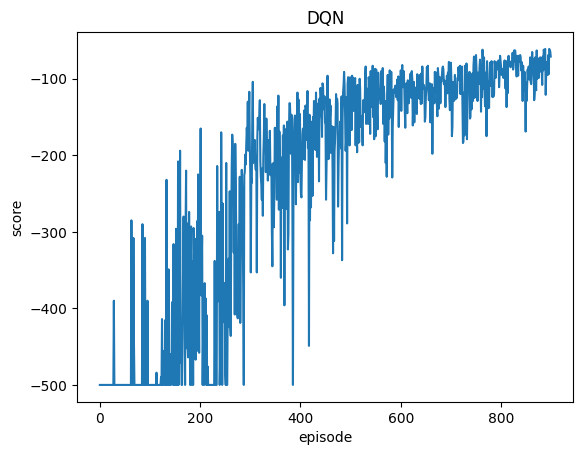

In [30]:

# Make an environment
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = DQNAgent(state_size, action_size)

# Train it
scoresDQN = train(agent, env)

plot_scores(scoresDQN, 'DQN')

![](https://i.imgur.com/jglC8zX.gif)

## N-Step DQN
N-step DQN is an improvement to Q-learning first introduced by Sutton in 1988 in Learning to Predict by the Methods of Temporal Differences.

To get the idea, let's look at the Bellman update used in Q-learning:

$$ Q(s_t, a_t) = r_t + \gamma \cdot max_aQ(s_{t+1}, a_{t+1}) $$

This equation is recursive, which means that we can express $Q(s_{t+1}, a_{t+1})$ in terms of itself, which gives us:

$$ Q(s_t, a_t) = r_t + \gamma \cdot max_a[r_{a, t+1} + \gamma \cdot max_{a'}Q(s_{t+2}, a')] $$

Value ra,t+1 means local reward at time t+1, after issuing action a. However, if we assume that action a at the step t+1 was chosen optimally, or close to optimally, we can omit the max operation and obtain this:

$$ Q(s_t, a_t) = r_t + \gamma r_{t+1} + \gamma^2max_{a'}Q(S_{t+2}, a') $$

This value can be unrolled again and again any number of times. As you may
guess, this unrolling can be easily applied to our DQN update by replacing one-step transition sampling with longer transition sequences of n-steps. 

### Implementation

1. **Initialization**: Begin by initializing the parameters for two neural networks, $Q(s,a)$ (referred to as the online network) and $\hat{Q}(s,a)$ (known as the target network), with random weights. Both networks serve the function of mapping a state-action pair to a Q-value, which is an estimate of the expected return from that pair. Also, set the exploration probability $\epsilon$ to 1.0, and create an empty replay buffer to store past transition experiences.

2. **Action Selection**: Utilize an epsilon-greedy strategy for action selection. With a probability of $\epsilon$, select a random action $a$, but in all other instances, choose the action $a$ that maximizes the Q-value, i.e., $a = argmax_aQ(s,a)$.

3. **Experience Collection**: Execute the chosen action $a$ within the environment emulator and observe the resulting immediate reward $r$ and the next state $s'$.

4. **Experience Storage**: Store the transition $(s,a,r,s')$ in the replay buffer for future reference. But instead of storing individual transitions, you store the last n steps as one experience $(s,a,R,s')$ where $R$ is the discounted sum of the rewards over the n steps. If you haven't completed n steps yet, then you estimate $R$ using the value of the next state $s'$ from the online network as an approximation for the remaining steps.

5. **Sampling**: Randomly sample a mini-batch of transitions from the replay buffer for training the online network.

6. **Target Computation**: For every transition in the sampled mini-batch, compute the target value $y$. If the episode has ended at this step, $y$ is simply the reward $R$. Otherwise, $y$ is the sum of the reward $R$ and the discounted estimated optimal future Q-value for the remaining steps, i.e., $y = R + \gamma^{n} \max_{a' \in A} \hat{Q}(s', a')$

7. **Loss Calculation**: Compute the loss, which is the squared difference between the Q-value predicted by the online network and the computed target, i.e., $\mathcal{L} = (Q(s,a) - y)^2$

8. **Online Network Update**: Update the parameters of the online network $Q(s,a)$ using Stochastic Gradient Descent (SGD) to minimize the loss.

9. **Target Network Update**: Every $N$ steps, update the target network by copying the weights from the online network to the target network $\hat{Q}(s,a)$.

Iterate: Repeat the process from step 2 until convergence.

This extension allows the DQN to take into account a longer trajectory in the calculation of the target Q-value, potentially leading to faster and more stable learning. The parameter n is a hyperparameter and can be tuned.

In [35]:
class NStepDQNAgent:
    '''
    This class is the same as the DQN class above with a few modifications.
    Changes have been highlighted.

    New Parameters
    ----------
    n_steps (int)
        The number of steps for n-step DQN
    '''
    def __init__(self, state_size=6, action_size=3, hidden_size=64, 
                 learning_rate=1e-6, gamma=0.99, buffer_size=10000, batch_size=64,
                 n_steps=2):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

        # Number of steps for n-step DQN
        self.n_steps = n_steps
        # Temporary buffer for n-step transitions
        # We need this as we need to delay pushing transitions into our main ReplayBuffer
        # until we've seen n steps into the future. This is so we can compute the n-step return
        self.n_step_buffer = deque(maxlen=n_steps)

    def step(self, state, action, reward, next_state, done):
        
        # Store experience to n-step buffer
        self.n_step_buffer.append((state, action, reward, next_state, done))

        # If our step_buffer is filled
        if len(self.n_step_buffer) == self.n_steps:
            self.push_to_memory()

        if done:
            while len(self.n_step_buffer) > 0:
                self.push_to_memory()

        # If we have enough experiences, learn, as in regular DQN
        if len(self.memory) > self.batch_size:
            self.update_model()

    def push_to_memory(self):
        # We format our transitions as (s, a, R, s')
            # Where:
            #   s is our starting state
            #   a is the first action we took in that state
            #   R is the total reward for taking a in s and a' in st+1 (or more for higher n_steps)
            #   s' is the final state we end up in after n steps
        state_0, action_0, _, _, _ = self.n_step_buffer[0]
        _, _, _, next_state_n, done_n = self.n_step_buffer[-1]

        # Sum of discount factor to the power of the step multiplied by reward for that step
        reward_n = sum(self.gamma**i * trans[2] for i, trans in enumerate(list(self.n_step_buffer)))
        # Push to our replay buffer
        self.memory.push(state_0, action_0, reward_n, next_state_n, done_n)
        # Pop the oldest experience out
        self.n_step_buffer.popleft()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  

            with torch.no_grad():
                action_values = self.q_network(state)

            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Compute the expected Q-values using the unrolled Bellman equation
        expected_q_values = rewards + self.gamma ** self.n_steps * next_q_values * (1 - dones)

        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

### N-Step DQN with n_steps = 2
Let's train our N-Steps DQN agent with n_steps=2. This agent should converge faster than the classic DQN implementation.

In [ ]:
# Make an environment
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = NStepDQNAgent(state_size, action_size, n_steps=2)
# Train it
scoresDQN2 = train(agent, env)

plot_scores(scoresDQN2, 'DQN - 2')

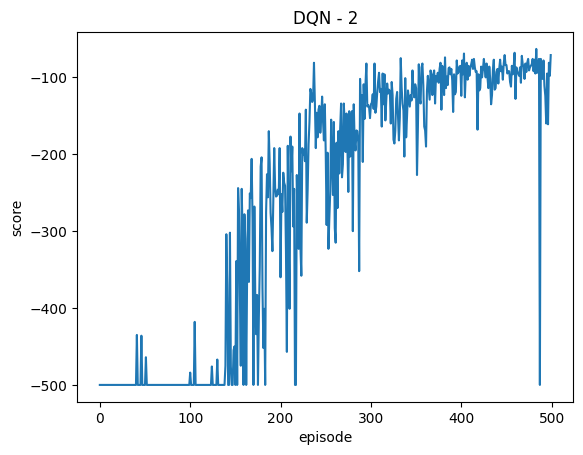

In [33]:
plot_scores(scoresDQN2, 'DQN - 2')

![](https://i.imgur.com/Zxcu6gs.gif)

#### Observations:
- 2-step DQN converges significantly faster than the regular DQN algorithm.
- Let's see if we can increase convergence speed even further with n_step=3 and n_steps=4

### n_steps = 3

In [ ]:
# Make an environment
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = NStepDQNAgent(state_size, action_size, n_steps=3)

# Train it
scoresDQN3 = train(agent, env)

plot_scores(scoresDQN3, 'DQN - 3')

Episode 100	Average Score: -481.07
Episode 200	Average Score: -287.41
Episode 300	Average Score: -149.07
Episode 400	Average Score: -105.60
Episode 500	Average Score: -99.722


![](https://i.imgur.com/2Ubr9D9.gif)

#### n_steps = 4

In [ ]:
# Make an environment
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = NStepDQNAgent(state_size, action_size, n_steps=4)

# Train it
scoresDQN4 = train(agent, env)

plot_scores(scoresDQN4, 'DQN - 4')

Episode 100	Average Score: -473.67
Episode 200	Average Score: -242.89
Episode 300	Average Score: -143.88
Episode 400	Average Score: -106.65
Episode 500	Average Score: -99.40


![](https://i.imgur.com/Ef2aTFR.gif)

In [36]:

# Make an environment
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = NStepDQNAgent(state_size, action_size, n_steps=6)

# Train it
scoresDQN6 = train(agent, env)

plot_scores(scoresDQN6, 'DQN - 6')

Episode 100	Average Score: -497.25
Episode 200	Average Score: -496.17
Episode 300	Average Score: -499.36
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00
Episode 882	Average Score: -500.00

KeyboardInterrupt: 